# AGH 
## Teoria Współbieżności
### Studia niestacjonarne, semestr 6.
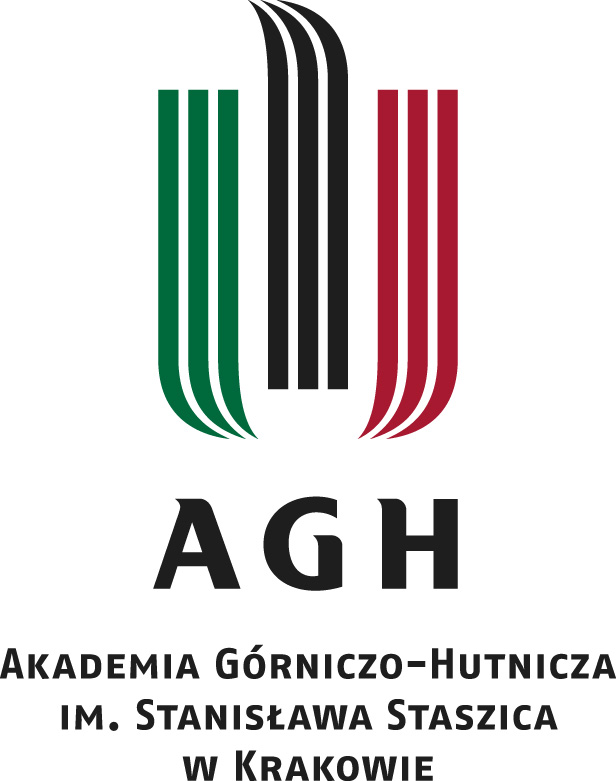

### Laboratorium 7: Problem 5 filozofów


#### Mateusz Popielarz




# Część teoretyczna

## O co chodzi?
Problem pięciu filozofów - inaczej zwany problemem ucztujących filozofów - jest to klasyczny problem synchronizacji procesów. 

Edsger Dijkstra w 1965r. wymyślił zadanie, gdy 5 komputerów próbuje uzyskać dostęp do 5 współdzielonych dysków, wkrótce został przedstawiony jako abstrakcyjny problem ucztujących filozoów.

## Przedstawienie

Pięciu filozofów siedzi przy stole i w jednym momencie albo je (korzysta z zasobu), albo rozmyśla (czeka). 
Każdy ma przed sobą talerz z makaronem spaghetti (ryż w innej wersji ), i na stole jest 5 widelców (pałeczek), aby jeść, trzeba mieć na własność conajmniej dwa widelce (pałeczki), bo inaczej 'ciężko się je'.

Filozofowie nie komunikują się ze sobą, może wystąpić zakleszczenie, gdy każdy podniesie jeden widelec, i będzie czekał na kolejny

Kolejnym problemem jest głodzenie - niektózy filozofowie będą jedli dużo rzadziej.

# Zadania


Do pomocy w rozwiązaniu zadań zostało napisane kilka dodatkowych pomocniczych funkcji - jako że to wypracowanie jest jednocześnie wykonwyalnym notatnikiem, poniższe funkcje wspomagają prezentacje danych. 
Poniższa funkcja odpowiada za łączenie wykresów w jeden

In [5]:
%maven org.knowm.xchart:xchart:3.5.2
import org.knowm.xchart.*;

import java.awt.image.*;
import java.util.stream.*;

public BufferedImage Combine(BufferedImage... images)
{
    var space = 10;
    var h = Stream.of(images).mapToInt(i->i.getHeight()).max().orElseThrow(NoSuchElementException::new);
    var w =  Stream.of(images).mapToInt(i -> i.getWidth() + space).sum();
    var result =new BufferedImage(w, h, BufferedImage.TYPE_INT_ARGB);
    var  g = result.getGraphics();
    int currentWidth = 0;
    for(var img : images){
        g.drawImage(img, currentWidth,0, null);
        currentWidth = currentWidth +space + img.getWidth();
    }
    g.dispose();
    return result;
}

public BufferedImage CombineY(BufferedImage... images)
{
    var space = 10;
    var w = Stream.of(images).mapToInt(i->i.getWidth()).max().orElseThrow(NoSuchElementException::new);
    var h =  Stream.of(images).mapToInt(i -> i.getHeight() + space).sum();
    var result =new BufferedImage(w, h, BufferedImage.TYPE_INT_ARGB);
    var  g = result.getGraphics();
    int cH = 0;
    for(var img : images){
        g.drawImage(img, 0, cH, null);
        cH = cH +space + img.getHeight();
    }
    g.dispose();
    return result;
}


## Ćwiczenie a.

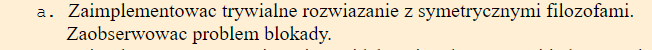


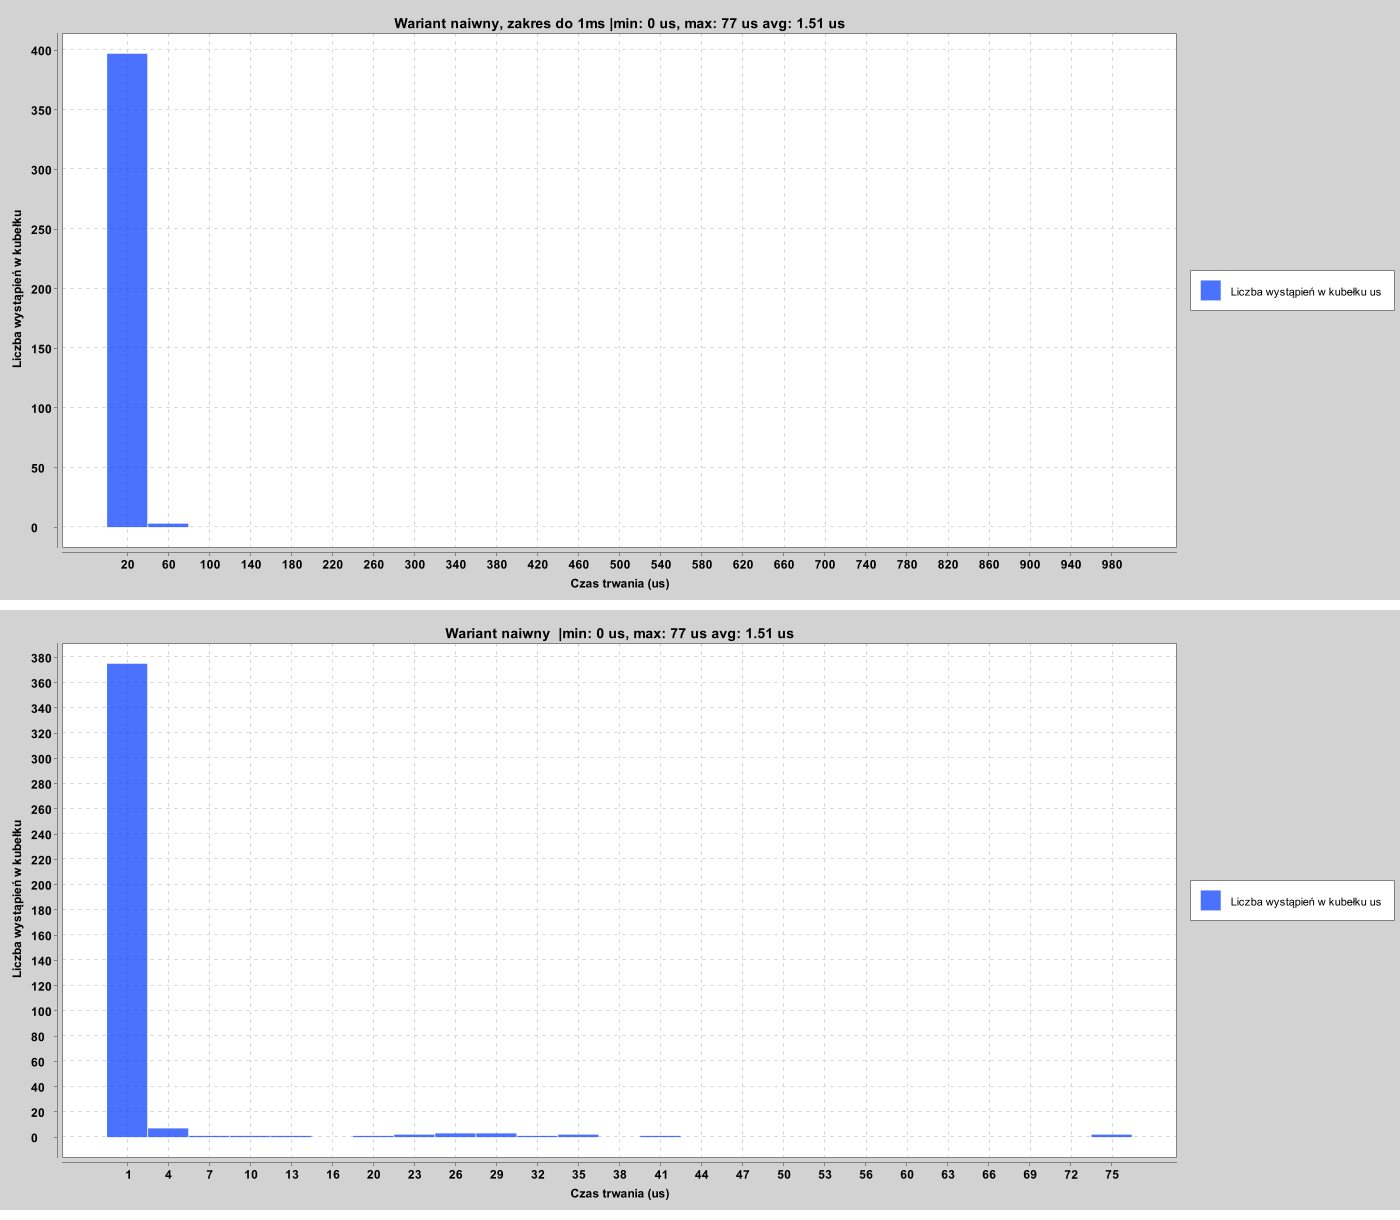

In [65]:
%maven org.knowm.xchart:xchart:3.5.2
import org.knowm.xchart.*;

import java.util.concurrent.locks.*;
import java.util.ArrayList;
import java.util.List;
import java.util.stream.Stream;
import java.util.stream.*;
import java.util.concurrent.TimeUnit;

var tries = 10;
var timeoutMilis = 1000;

void writeLine(String text) {
    //System.out.println(text);
}

public class Widelec {
    public int n;
    
    public Widelec(int n){
        this.n = n; 
    }
    
  private final Semaphore available = new Semaphore(1, true);
    
  public void podnies() throws InterruptedException {
     if(!this.available.tryAcquire(timeoutMilis, TimeUnit.MILLISECONDS))
     {
         throw new InterruptedException();
     }
  }
  public void odloz() {
     this.available.release();
  }
}

class Filozof extends Thread {
    public Widelec left;
    public Widelec right;
    private int _licznik = 0;
    public List<Long> waits = new ArrayList<Long>();    
    public Filozof(Widelec left, Widelec right){
        this.left = left;
        this.right = right;
    }
    
    public void run()  {
        try{
            while (true) {
                var start = System.nanoTime();

                this.left.podnies();
                this.right.podnies();
                var time = System.nanoTime() - start;
                waits.add(time);
                // jedzenie
                ++_licznik;
                if (_licznik % 100 == 0) {
                    writeLine("Filozof: " + Thread.currentThread() +               "jadlem " + _licznik + " razy");
                }
                // koniec jedzenia
                this.right.odloz();
                this.left.odloz();
            }
        }
        catch(InterruptedException ie){
            writeLine("Filozof " + this.getName() + " został w stanie deadlock (po "  + timeoutMilis + " ms)") ;
            try{ 
                Thread.sleep(500);
            }
            catch (Exception e){
            }
        }
    }
}

public List<Long> startEx1() {
    var forks = new ArrayList<Widelec>();
    for(int i = 0; i < 5; i++){
        forks.add(new Widelec(i));
    }
    var philos = new ArrayList<Filozof>();
    philos.add(new Filozof(forks.get(0), forks.get(1)));
    philos.add(new Filozof(forks.get(1), forks.get(2)));
    philos.add(new Filozof(forks.get(2), forks.get(3)));
    philos.add(new Filozof(forks.get(3), forks.get(4)));
    philos.add(new Filozof(forks.get(4), forks.get(0)));

    var waitTimes = new ArrayList<Long>();
    
    for(var p : philos){
        p.setName("Filozof [" + p.left.n + ", " + p.right.n + "]");
        p.start();
    }
    for(var p: philos) {
        try{ p.join(); }
        catch(InterruptedException ie){ }
        waitTimes.addAll(p.waits);
    }
    return waitTimes;
}



public BufferedImage GetChart(String title, String units, Collection<Long> data, int limit){
    var histogram = limit == 0 ?new Histogram(data, 25) : new Histogram(data ,25, 0, limit);
    var average = data.stream().mapToLong(a->a).average().orElse(0);
    var chart = new CategoryChartBuilder().width(1400).height(600).title(title + " |min: " + Collections.min(data) + " " + units + ", max: " + Collections.max(data) +" " + units + " avg: " + average + " " + units)
        .xAxisTitle("Czas trwania (" + units + ")")
        .yAxisTitle("Liczba wystąpień w kubełku").build();
    chart.getStyler().setAvailableSpaceFill(.98);
    chart.getStyler().setOverlapped(true);
    var xes =     histogram.getxAxisData().stream().map(p -> p.intValue()).collect(Collectors.toList());
    chart.addSeries("Liczba wystąpień w kubełku " + units, xes, histogram.getyAxisData());
    return BitmapEncoder.getBufferedImage(chart);
  
}


var data = startEx1();
data = data.stream().mapToLong(a->a/1000).boxed().collect(Collectors.toList());
public var data1us = data;
CombineY(
GetChart("Wariant naiwny, zakres do 1ms", "us", data, 1000),
GetChart("Wariant naiwny ", "us", data, 0)
)

Widzimy, że większość przypadków czasu oczekiwania są w okolicy 100ms. Czas po którym uznałem, że będzie deadlock (lub jakiś wariant w postaci livelock) to 1s.

# Ćwiczenie b.
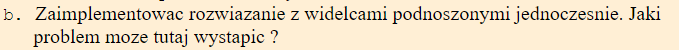

W tym rozwiązaniu filozof ma semafor - furtka - jest najpierw zamknięty, jest on otwierany, gdy może rozpocząć jedzenie - będzie próbował jednocześnie podnieść widelce



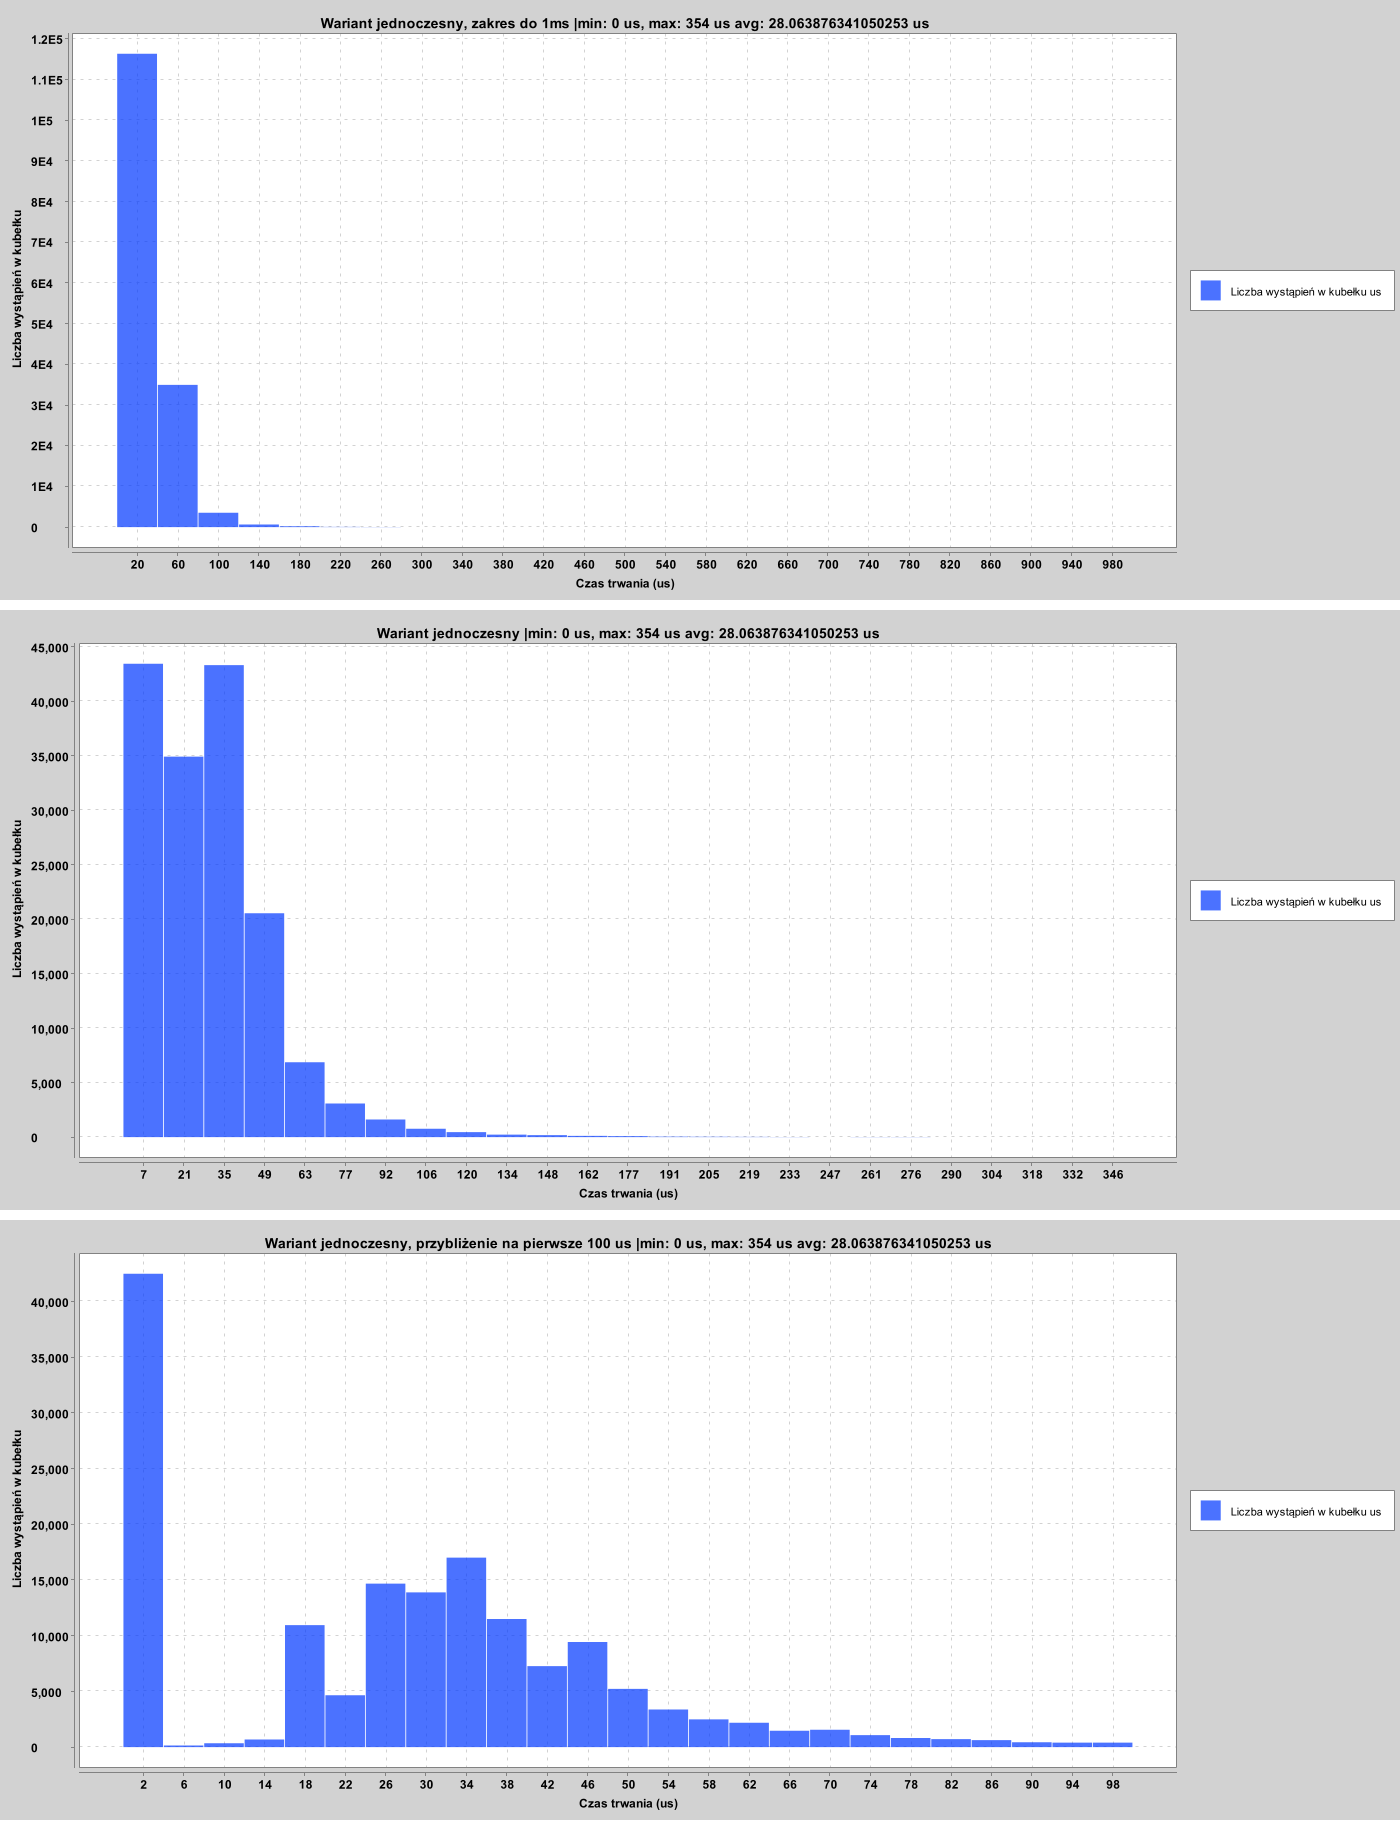

In [69]:
var thing = 0;
var hungry = 1;
var eats = 2;

class Filozof2 extends Thread {
    public List<Long> waits = new ArrayList<Long>();    
    private Semaphore mutex;
    public int state;
    public Semaphore gate = new Semaphore(1);
    private List<Filozof2> philos;
    public int index;
    private Boolean run = true;
    
    void test(int i){
        i = i % 5;
        if(philos.get(i).state == hungry && philos.get((i + 1) % 5).state != eats && philos.get((i + 4) % 5).state != eats){
             philos.get(i).state = eats;
            philos.get(i).gate.release();
        }
    }
    
     public void cancel(){
        this.run = false;
    }
    
    public Filozof2(Semaphore mutex, List<Filozof2> philos, int i){
        this.mutex = mutex;
        this.philos = philos;
        this.index = i;
    }
    
    public void run() {
        while(this.run)
        {
            // Mysli
            mutex.acquireUninterruptibly();
            this.state = hungry;
            test(this.index);
            mutex.release();
            var start = System.nanoTime();
            this.gate.acquireUninterruptibly();
            mutex.acquireUninterruptibly();
            var time = System.nanoTime() - start;
            if(this.run)
            waits.add(time);

            // je
            this.state = thing;
            test(index + 4);
            test(index + 1);
            mutex.release();
        }        
    }
}

public List<Long> startEx2() throws InterruptedException{
    var mutex = new Semaphore(1);
    var philos = new ArrayList<Filozof2>();
    philos.add(new Filozof2(mutex,philos,0));
    philos.add(new Filozof2(mutex,philos,1));
    philos.add(new Filozof2(mutex,philos,2));
    philos.add(new Filozof2(mutex,philos,3));
    philos.add(new Filozof2(mutex,philos,4));
    
    var waitTimes = new ArrayList<Long>();
    
     for(var p : philos){
        p.setName("Filozof [" + p.index+ "]");
        p.start();
    }
    Thread.sleep(1000);
    for(var p: philos){ p.cancel(); }
    for(var p: philos){ 
        try {
            p.join();
        }
        catch(InterruptedException ie){}
        waitTimes.addAll(p.waits);
    }
    return waitTimes;
}

var data2 = startEx2();
var data2ns = data2.stream().mapToLong(a->a).boxed().collect(Collectors.toList());
public var data2us = data2.stream().mapToLong(a->a/1000).boxed().collect(Collectors.toList());
var max2 = Collections.max(data2us);
CombineY(
GetChart("Wariant jednoczesny, zakres do 1ms", "us", data2us, 1000),
GetChart("Wariant jednoczesny", "us", data2us, 0),
GetChart("Wariant jednoczesny, przybliżenie na pierwsze 100 us", "us", data2us, 100)
    
)

Możemy zauważyć, że w tym przypadku nie doszło do zakleszczenia - program działał poprawnie - patrząc na histogram czasów oczekiwania możemy zobaczyć, że to rozwiązanie nie tylko jest prawidłowe (nie powoduje zakleszczenia), ale też dużo wydajniejsze niż 1.

Patrząc na maksymalny czas oczekiwania można zauważyć, że czasami któryś z filofów musiał być głodzony nawet do kilku ms, ale patrząc na rozkład możemy wyciągnąć wniosek, że zdarzało się to rzadko (z wykresu możemy odczytać, że najwięcej oczekiwań występowało koło 40 us.

## Ćwiczenie c.



Do przedstawienia tego problemu zostanie zastosowany dodatkowy semafor, który będzie określał ilość jednocześnie "jedzących" filozofów - 4. W ten sposób pozbędziemy się problemu zakleszczenia. W tym celu stworzymy nowy semafor i ustawimy jego wartość na jeden mniejszą niż liczbę filozofów. Jako, że nie możemy liczyć na zakończenie algorytmu poprzez deadlock wszyskich filozofów (tu deadlock nie wystąpi), musimy zastosować inny warunek stopu - dla mnie to będzie 1s pracy filozofów.

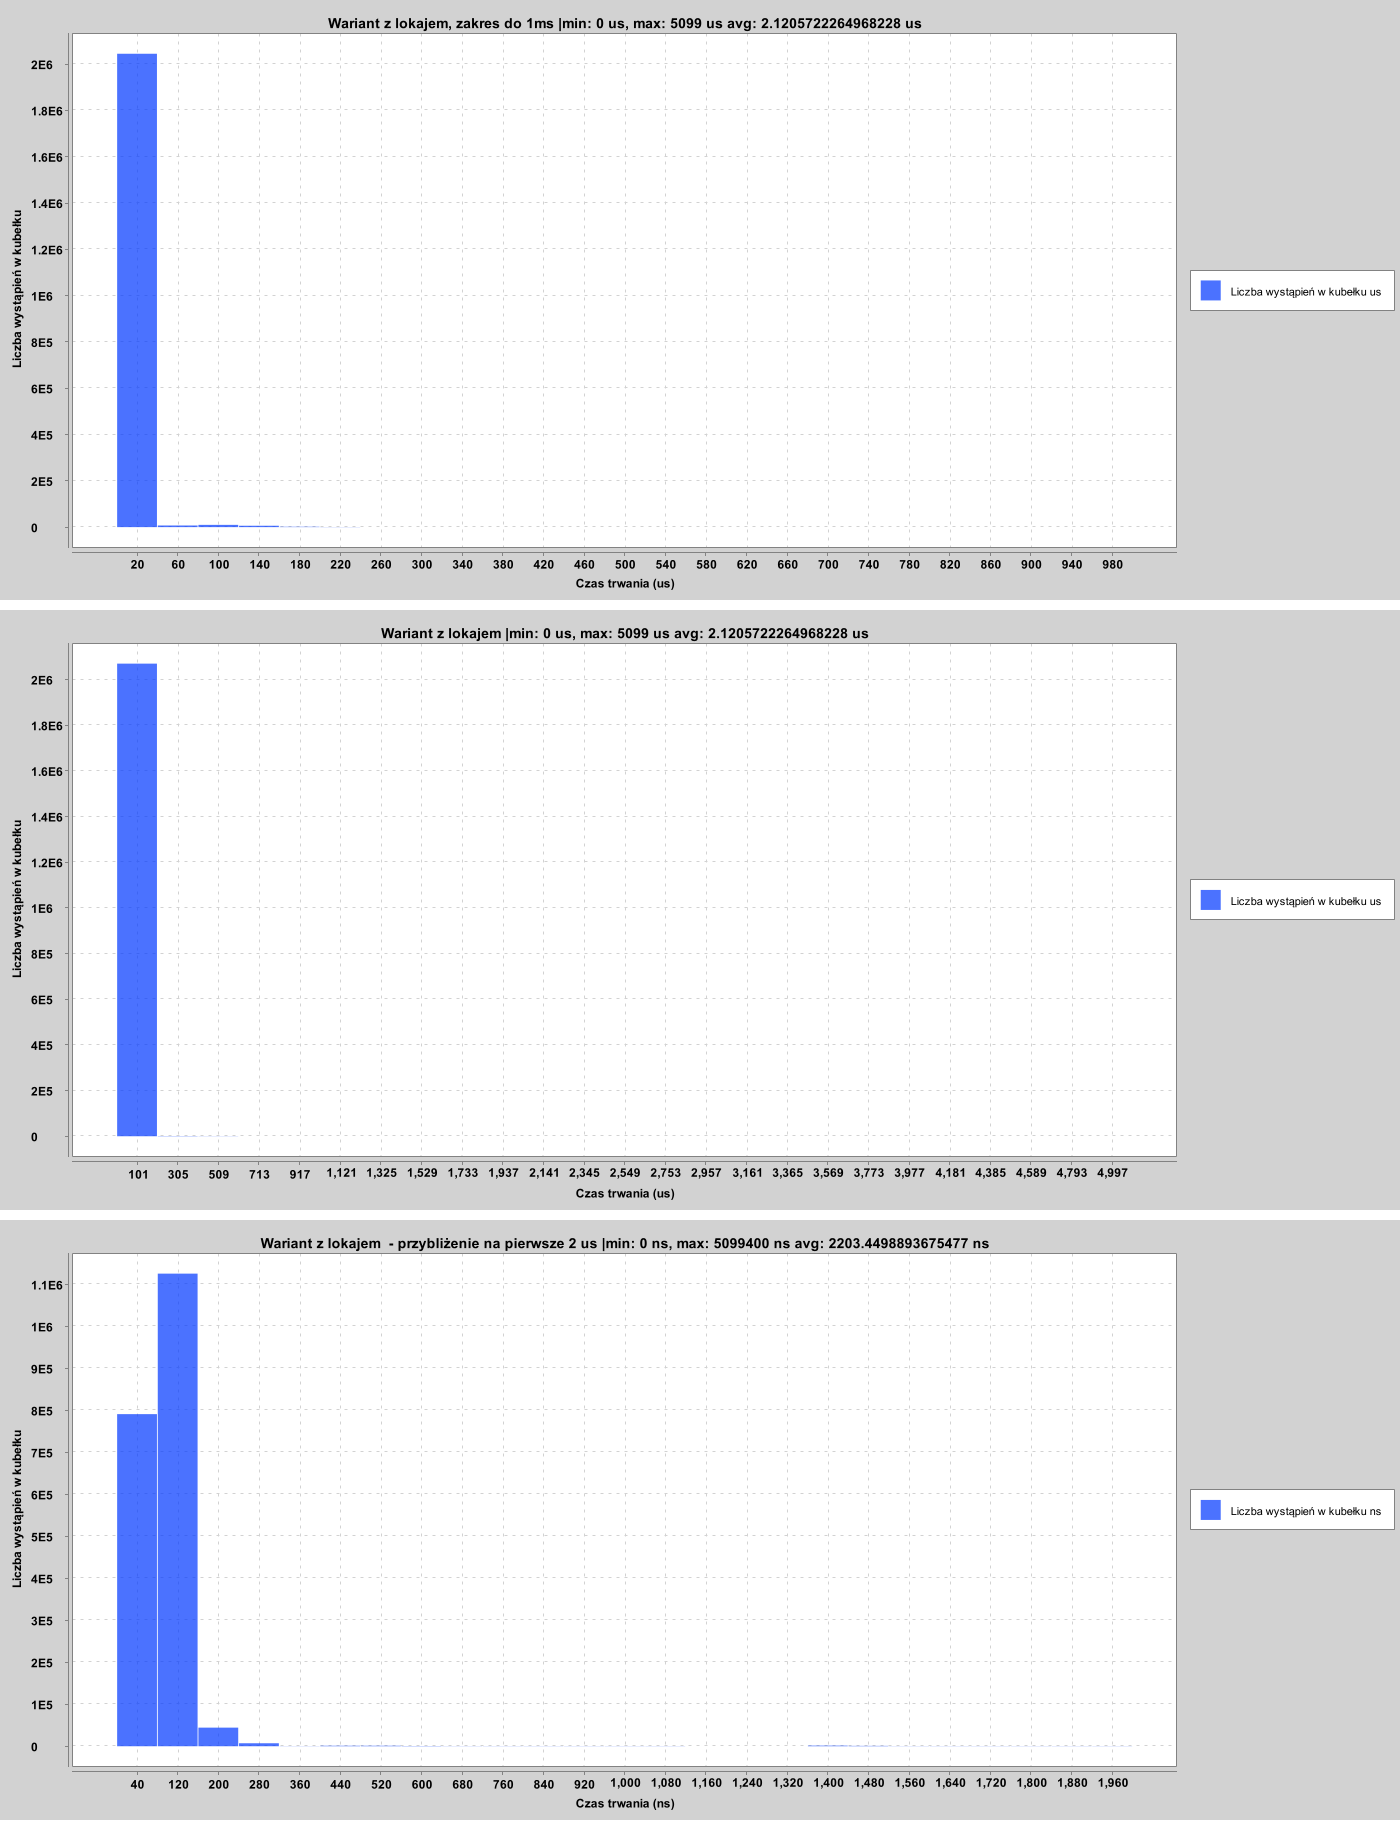

In [75]:

public void writeLine(String s) { }
class Filozof3 extends Thread {
    private volatile Boolean run = true;
    public Widelec left;
    public Widelec right;
    private int _licznik = 0;
    private Semaphore tickets;
    
    public List<Long> waits = new ArrayList<Long>();    
    public Filozof3(Widelec left, Widelec right, Semaphore tickets){
        this.left = left;
        this.right = right;
        this.tickets = tickets;
    }
    
    public void cancel(){
        this.run = false;
    }
    
    public void run()  {
        try{
            while (this.run) {
                var start = System.nanoTime();
                tickets.acquireUninterruptibly();
                this.left.podnies();
                this.right.podnies();
                var time = System.nanoTime() - start;
                if(this.run)
                waits.add(time);
                // jedzenie
                ++_licznik;
                if (_licznik % 100 == 0) {
                    writeLine("Filozof: " + Thread.currentThread() +               "jadlem " + _licznik + " razy");
                }
                // koniec jedzenia
                this.right.odloz();
                this.left.odloz();
                tickets.release();
            }
            
        }
        catch(InterruptedException ie){
            writeLine("Filozof " + this.getName() + " został w stanie deadlock (po "  + timeoutMilis + " ms)") ;
            try{ 
                Thread.sleep(2000);
            }
            catch (Exception e){
            }
        }
    }
}

public List<Long> startEx3() throws InterruptedException {
    var forks = new ArrayList<Widelec>();
    for(int i = 0; i < 5; i++){
        forks.add(new Widelec(i));
    }
    
    var tickets = new Semaphore(3);
    var philos = new ArrayList<Filozof3>();
    philos.add(new Filozof3(forks.get(0), forks.get(1), tickets));
    philos.add(new Filozof3(forks.get(1), forks.get(2), tickets));
    philos.add(new Filozof3(forks.get(2), forks.get(3), tickets));
    philos.add(new Filozof3(forks.get(3), forks.get(4), tickets));
    philos.add(new Filozof3(forks.get(4), forks.get(0), tickets));

    var waitTimes = new ArrayList<Long>();
    
    for(var p : philos){
        p.setName("Filozof [" + p.left.n + ", " + p.right.n + "]");
        p.start();
    }
    Thread.sleep(1000);
    for(var p: philos){ p.cancel(); }
    for(var p: philos){ 
        try {
            p.join();
        }
        catch(InterruptedException ie){}
        
        waitTimes.addAll(p.waits);
    }
    return waitTimes;
}


var data3 = startEx3();
var data3ns = data3.stream().mapToLong(a->a).boxed().collect(Collectors.toList());
public var data3us = data3.stream().mapToLong(a->a/1000).boxed().collect(Collectors.toList());

CombineY(
GetChart("Wariant z lokajem, zakres do 1ms", "us", data3us, 1000),
GetChart("Wariant z lokajem", "us", data3us, 0),
GetChart("Wariant z lokajem  - przybliżenie na pierwsze 2 us", "ns", data3ns, 2000)
)

Warto zauważyć, że średni czas oczekiwania jest w okolicy 2.5 ms, jest około 35 razy mniejszy niż w ćwiczeniu z implementacją trywialną i 10 razy mniejszy niż implementacja jednoczesna - warto też zauważyć, że ilość spożywań znacznie wzrosła w porównaniu do punktu 1. podobnie jak w punkcie 2.

Ta metoda daje nam bardzo niski średni czass wykonania i w większości przypadków gwarantuje wysoki 99 percentyl (mieszczący się w kubełku 20us), ale coś za coś - dostajemy bardzo wysoki maksymalny czas wykonania, rzędu milisekund, jest to rząd wielkości więcej niż w 2. zadaniu.

## Wnioski

`Nie ma darmowych obiadów` - chciałoby się nawiązać do słynnego cytatu. Żadne z przedstawionych rozwiązań nie jest bez wad - sposób 1. jest prosty w implementacji, ale niepoprawny - potrafi spowodować zawieszenie się programu, sposób 2. jest poprawny, ale średni czas oczekiwania jest całkiem duży, a także instnieje głodzenie niektórych wątków a 3. rozwiązanie ma dużo krótszy średni czas oraz dystrybucja czekania jest największa w okolicach 120 ns (rząd wielkości nizej niż w 2.), ale za to mamy problem z wysokim maksymalnym czasem oczekiwania.

W zależności od problemu powinniśmy zastosować inne rozwiązanie, gdy jest nam potrzebne najwyższa wydajność rozwiązaniem będzie wersja 3. ,a gdy potrzebujemy głównie stabilnego czasu odpowiedzi najlepsze będzie rozwiązanie 2.


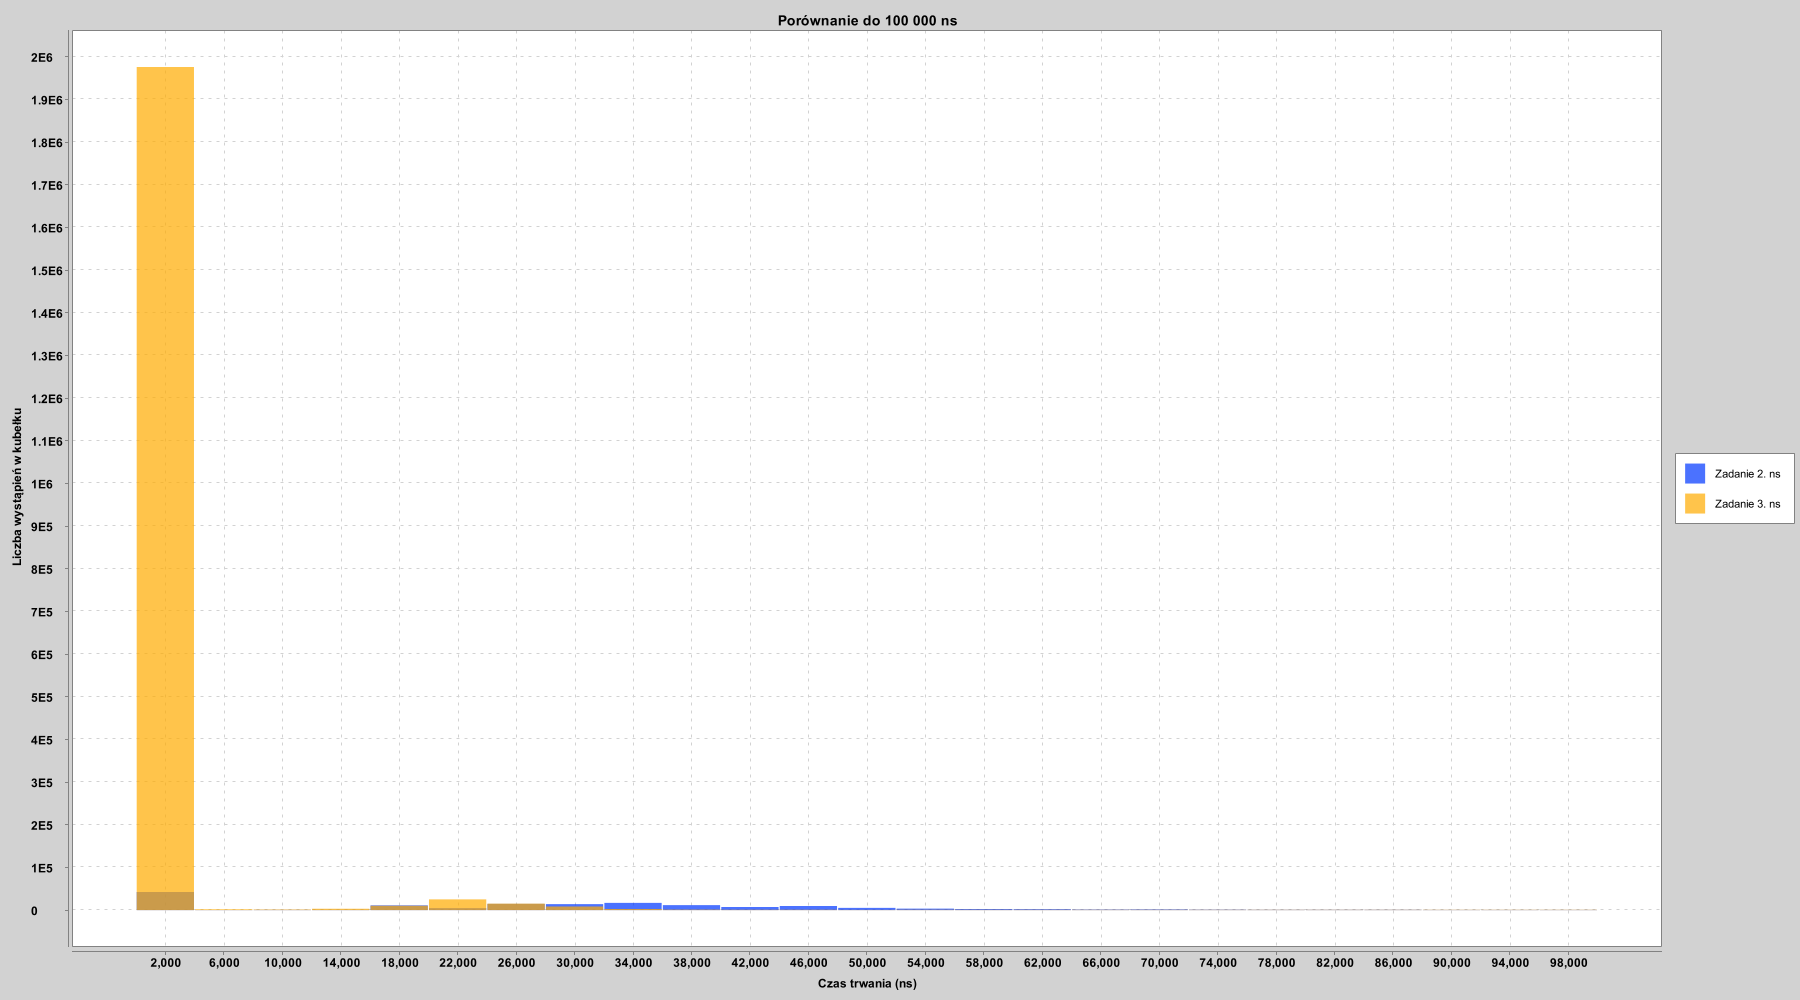

In [86]:
var histogram2 = new Histogram(data2ns, 25, 0, 100000);
var histogram3 = new Histogram(data3ns, 25, 0, 100000);

var units = "ns";
var chart = new CategoryChartBuilder().width(1800).height(1000).title("Porównanie do 100 000 ns")
        .xAxisTitle("Czas trwania (" + units + ")")
        .yAxisTitle("Liczba wystąpień w kubełku").build();

chart.getStyler().setAvailableSpaceFill(.98);
chart.getStyler().setOverlapped(true);
chart.getStyler().setYAxisLogarithmicDecadeOnly(true);

var xes2 = histogram2.getxAxisData().stream().map(p -> p <= 0 ? 1 : p.intValue()).collect(Collectors.toList());
var yes2 = histogram2.getyAxisData().stream().map(p -> p <= 0 ? 1 : p.intValue()).collect(Collectors.toList());

var xes3 = histogram3.getxAxisData().stream().map(p -> p <= 0 ? 1 : p.intValue()).collect(Collectors.toList());
var yes3 = histogram3.getyAxisData().stream().map(p -> p <= 0 ? 1 : p.intValue()).collect(Collectors.toList());

chart.addSeries("Zadanie 2. " + units, xes2, yes2);
chart.addSeries("Zadanie 3. " + units, xes3, yes3);
BitmapEncoder.getBufferedImage(chart);


Wykres porównujący wydajność rozwiązanie 2. i 3. - widzimy znaczną przewagę rozwiązania 3. w kwestii wydajności.

# Bibliografia 

1. https://www.benchresources.net/how-to-sort-hashset-in-java-2-ways/
2. https://docs.oracle.com/javase/7/docs/api/java/util/concurrent/locks/Condition.html
3. https://askldjd.com/2010/01/14/pipeline-concurrency-pattern/
4. https://pl.wikipedia.org/wiki/Przetwarzanie_potokowe
5. http://wazniak.mimuw.edu.pl/index.php?title=PWR_Wyk%C5%82ad_9&fbclid=IwAR0RerGXuNFBuBMMmMiJqd_IM2KsGw9ZNE_kYvSWOZnJWbMPA5JLsaASaiU